# INF-0616 - Projeto 2: Redes neurais

Professora: Esther Colombini -- esther@ic.unicamp.br

Monitor: Jesus Paucar -- j236865@dac.unicamp.br

Este *notebook* faz parte da disciplina INF-0616 no curso de extensão MDC.  

Nomes:
- Vitor de Oliveira Fernandez Araujo
- Vitor Sancho Cardoso

Instituto de Computação - Unicamp 2025

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD

from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

from IPython.display import display

In [3]:
plt.rcParams['figure.figsize'] = (12, 6)

#### Lendo o conjunto de dados

O conjunto de dados consiste em reclamações de clientes a cerca de produtos/serviços oferecidos em uma instituição bancária. ***Garanta que o arquivo*** `customer-issues.csv` ***está no mesmo diretório do notebook***.

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')
# import os
# caminho_pasta = '/content/drive/My Drive/Colab/MDC/AULA4/'

# # Verifique se o caminho da pasta existe
# if os.path.exists(caminho_pasta):
#     # Mude o diretório atual para a pasta desejada
#     os.chdir(caminho_pasta)
#     print("Pasta encontrada. Agora você está na pasta:", caminho_pasta)
# else:
#     print("A pasta especificada não existe:", caminho_pasta)

d = pd.read_csv('customer-issues.csv')
display(d.head())


,date-received,product,sub-product,issue,sub-issue,consumer-message,state,zip-code,tags,via,resolution,timely-response?,disputed?,complaint-id
0,10/1/2016,Credit reporting,NaN,Incorrect information on credit report,Account status,I have outdated information on my credit repor...,AL,352XX,NaN,Web,Closed with explanation,Yes,No,2141773
1,10/17/2016,Consumer Loan,Vehicle loan,Managing the loan or lease,NaN,I purchased a new car on XXXX XXXX. The car de...,PA,177XX,Older American,Web,Closed with explanation,Yes,No,2163100
2,6/15/2015,Credit reporting,NaN,Credit reporting company's investigation,Inadequate help over the phone,An account on my credit report has a mistaken ...,VA,224XX,NaN,Web,Closed with explanation,Yes,No,1420702
3,2/3/2016,Debt collection,"Other (i.e. phone, health club, etc.)",Disclosure verification of debt,Not given enough info to verify debt,This company refuses to provide me verificatio...,TX,752XX,NaN,Web,Closed with explanation,Yes,Yes,1772196
4,2/17/2016,Debt collection,Credit card,Improper contact or sharing of info,Talked to a third party about my debt,This complaint is in regards to Square Two Fin...,NE,693XX,NaN,Web,Closed with explanation,Yes,Yes,1790634


##### Exibindo as quatro primeiras mensagens

In [5]:
print(*d.loc[:4, 'consumer-message'], sep='\n\n')

I have outdated information on my credit report that I have previously disputed that has yet to be removed this information is more then seven years old and does not meet credit reporting requirements

I purchased a new car on XXXX XXXX. The car dealer called Citizens Bank to get a 10 day payoff on my loan, good till XXXX XXXX. The dealer sent the check the next day. When I balanced my checkbook on XXXX XXXX. I noticed that Citizens bank had taken the automatic payment out of my checking account at XXXX XXXX XXXX Bank. I called Citizens and they stated that they did not close the loan until XXXX XXXX. ( stating that they did not receive the check until XXXX. XXXX. ). I told them that I did not believe that the check took that long to arrive. XXXX told me a check was issued to me for the amount overpaid, they deducted additional interest. Today ( XXXX XXXX, ) I called Citizens Bank again and talked to a supervisor named XXXX, because on XXXX XXXX. I received a letter that the loan had b

##### Extraíndo um conjunto de testes válido

As mensagens contidas neste conjunto possuem uma relação temporal.
É importante realizar a separação dos sub-conjuntos de treino/teste respeitando esta relação, de forma a garantir que o modelo não seja treinado sobre amostras no futuro e experimentado sobre o passado.

In [6]:
np.random.seed(42)
d.sort_values(by='date-received', inplace=True)

### Modelando a classificação de tópicos baseado nas mensagens de clientes

Observando no gráfico de frequências de produto sobre as conversas que este é um problema extremamente desbalanceado. Há, entretanto, amostras suficientes para a modelagem de um estimador de tópico (de produto) levando em consideração o diálogo do cliente.

In [7]:
def frequencies(dataset, column):
    labels, counts = np.unique(dataset[column], return_counts=True)
    p = np.argsort(counts)[::-1]
    labels, counts = labels[p], counts[p]

    (sns
     .barplot(x=[l[:40] for l in labels], y=counts)
     .set_title(f'Occurrences for The {len(labels)} Classes in {column}'))
    plt.xticks(rotation=90)

    return labels, counts

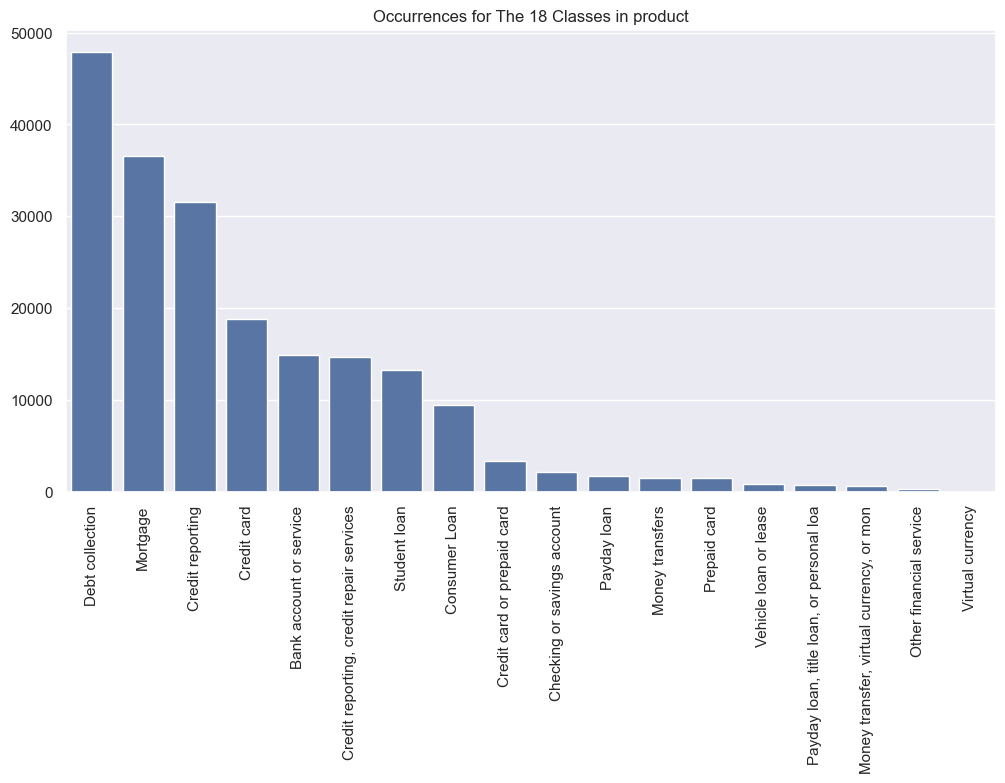

In [8]:
labels, counamts = frequencies(d, 'product')

Simplificamos o problema, considerando somente as 6 classes mais frequentes:

In [9]:
np.random.seed(42)
s = d['product'].isin(labels[:6])
d = d[s]

test_share = .3

d_train, d_test = train_test_split(d, test_size=test_share, shuffle=False)
assert d_train['date-received'].max() <= d_test['date-received'].min()

x_train, x_test = d_train['consumer-message'], d_test['consumer-message']
y_train, y_test = d_train['product'], d_test['product']

Vamos codificar as palavras na conversa utilizando o TF-IDF, gerando um vetor de características baseadas nas frequências de ocorrência das palavras no documento e em todo o conjunto de dados.

In [10]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

features = 1024

encoder = make_pipeline(TfidfVectorizer(min_df=5,
                                        stop_words='english',
                                        strip_accents='unicode',
                                        max_features=features),
                        StandardScaler(with_mean=False))

x_train = encoder.fit_transform(x_train)
x_test = encoder.transform(x_test)

label_enc = LabelEncoder()
ye_train = label_enc.fit_transform(y_train)
ye_test = label_enc.transform(y_test)

## Treinando um regressor logístico para classificar produto
**Atividade (1 pt):** treine um regressor logístico, buscando os hiper-parâmetros com *grid-search*.

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
np.random.seed(42)

LR = LogisticRegression(
        max_iter=1000,
        random_state=42
    )

grid = {
    "C": [1e-3, 1e-2, 1e-1, 1, 10, 100],
    "class_weight": [None, "balanced"]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

g = GridSearchCV(
    estimator=LR,
    param_grid=grid,
    scoring="balanced_accuracy",
    cv=cv,
    n_jobs=-1,
    refit=True
)
g.fit(x_train, ye_train)


Iremos calcular a matriz de confusão relativa $R$, que guarda porcentagens de incidências em vez das contagens absolutas, e plotar o heatmap dessa matriz. Além disso, iremos calcular a distribuição de confiança nas predições por classe (mais próximos de `1.0` --> mais confiante):

In [ ]:
def evaluate(y, p, probabilities, labels=None):
    # Cálculo das métricas de acerto.
    print(f'Accuracy: {metrics.accuracy_score(y, p):.3f}')
    print(f'Accuracy (balanced): {metrics.balanced_accuracy_score(y, p):.3f}')

    # Calculo da matriz de confusão.
    c = metrics.confusion_matrix(y, p)
    r = c / c.sum(axis=1, keepdims=True)

    # Impressão dos gráficos.
    (plt
     .figure(figsize=(16, 12))
     .suptitle('Matriz de confusão', fontsize=20))
    sns.heatmap(r,
                cmap="YlGnBu", linewidths=.5, annot=True, fmt=".1%",
                xticklabels=labels, yticklabels=labels, cbar=False)

    (plt
     .figure(figsize=(16, 12))
     .suptitle('Distribuição de confiança para cada classe', fontsize=20))

    for i in np.unique(y):
        # Para cada classe `i`, seleciona suas amostras e filtra a confiança
        # do modelo em predizer estas amostras como sendo da classe `i`.
        sns.kdeplot(x = probabilities[y.ravel() == i][:, i],
                    fill = True,
                    label = labels[i] if labels is not None else f'Classe {i}',
                    alpha = 0.4)

    plt.xlabel("Confiança do modelo")
    plt.ylabel("Densidade")
    plt.legend()

Vamos utilizar a função `evaluate` para avaliar o modelo treinado anteriormente:

In [ ]:
evaluate(ye_test, g.predict(x_test), g.predict_proba(x_test), labels=label_enc.classes_)

**Pergunta (1pt):** considerando o gráfico de distribuição de confiança para o seu modelo treinado, as amostras são classificadas com alta confiança? Há uma grande diferença de confiança entre as diferentes classes?

A confiança do modelo na maioria das classes é boa, com uma concentração expressiva entre 80% e 100%. No entanto, conseguimos perceber um espalhamento maior da distribuição para as classes "Credit reporting" e "Credit reporting, credit repair services, or other personal consumer reports". Esta diferença também é visível na matriz de confusão, onde é nítida a queda de acurácia entre as duas classes. Essa queda de performance faz sentido, já que os dois temas são ambíguos, tendo a ver com relatórios de crédito. As classes de "Bank account or service" e "Credit card" também apresentam um pouco de ambiguidade entre si, porém em nível muito menor. Este comportamento pode ser visto como um ligeiro aumento na cauda das distribuições de ambas as classes e ao observar as suas respectivas linhas na matriz de confusão (falsos positivos).

----------
----------

## Redes Neurais - Tensorflow
Iremos treinar alguns modelos de redes neurais, variando número de camadas e quantidade de neurônios em cada camada.

Vamos converter os rótulos em vetores *One Hot Encoded*:

In [36]:
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input, BatchNormalization
from keras.regularizers import L2, L1, L1L2
from sklearn.utils.class_weight import compute_class_weight
from keras import optimizers
from keras.losses import CategoricalCrossentropy
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

y_ohe_train = to_categorical(ye_train, num_classes=6)
y_ohe_test = to_categorical(ye_test, num_classes=6)

class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(y_train), y=y_train)
train_class_weights = dict(enumerate(class_weights))

**Atividade (1 pt):** defina uma arquitetura de uma rede neural capaz de classificar os diferentes produtos a partir da conversa dos clientes. Compile a sua rede com a loss `categorical_crossentropy`, optimizador `SGD` e defina as métricas relevantes para o problema.

In [12]:
model = Sequential([
    Input(shape=(features,)),
    Dense(10, activation='relu'),
    Dense(6, activation='softmax')
])

model.compile(
    optimizer=optimizers.SGD(learning_rate=1e-2, momentum=0.9),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


### Treinando a rede neural

**Atividade (1 pt):** treine o modelo definido acima sobre o conjunto, respeitando as seguintes regras:

1. Separe um subconjunto do treino para validação.
2. Utilize alguma técnica para conservar os parâmetros que melhor generalizam o problema, como `ModelCheckpoint` (salve o modelo com nome de `weights.h5`).

In [13]:
nn_X_train, nn_X_val, nn_y_train, nn_y_val = train_test_split(x_train, y_ohe_train, test_size=0.2, stratify=y_train, random_state=42)
nn_X_test, nn_y_test = x_test, y_ohe_test

In [14]:
tf.random.set_seed(42)
np.random.seed(42)
epochs = 20
batch_size = 128


checkpoint = ModelCheckpoint(
    filepath="weights.h5",
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

earlystop = EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    nn_X_train, nn_y_train,
    validation_data=(nn_X_val, nn_y_val),
    epochs=epochs,
    batch_size=batch_size,
    class_weight=train_class_weights,
    callbacks=[checkpoint, earlystop],
    verbose=1
)

Epoch 1/20
716/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6408 - loss: 1.0211
Epoch 1: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7347 - loss: 0.7747 - val_accuracy: 0.7735 - val_loss: 0.6094
Epoch 2/20
704/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7965 - loss: 0.6064
Epoch 2: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7974 - loss: 0.6020 - val_accuracy: 0.7813 - val_loss: 0.5951
Epoch 3/20
720/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8052 - loss: 0.5765
Epoch 3: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8053 - loss: 0.5754 - val_accuracy: 0.7849 - val_loss: 0.5890
Epoch 4/20
709/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8097 - loss: 0.5591
Epoch 4: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8102 - loss: 0.5580 - val_accuracy: 0.7874 - val_loss: 0.5873
Epoch 5/20
713/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8134 - loss: 0.5467
Epoch 5: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8136 - loss: 0.5449 - val_accuracy: 0.7876 - val_loss: 0.5886
Epoch 6/20
709/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8171 - loss: 0.5368
Epoch 6: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8171 - loss: 0.5351 - val_accuracy: 0.7887 - val_loss: 0.5886
Epoch 7/20
695/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8204 - loss: 0.5279
Epoch 7: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8194 - loss: 0.5266 - val_accuracy: 0.7883 - val_loss: 0.5939
Epoch 8/20
718/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8235 - loss: 0.5199
Epoch 8: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8222 - loss: 0.5192 - val_accuracy: 0.7907 - val_loss: 0.5937
Epoch 9/20
697/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8261 - loss: 0.5134
Epoch 9: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8245 - loss: 0.5125 - val_accuracy: 0.7909 - val_loss: 0.5999
Epoch 10/20
691/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8268 - loss: 0.5082
Epoch 10: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8254 - loss: 0.5076 - val_accuracy: 0.7882 - val_loss: 0.6044
Epoch 11/20
703/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8283 - loss: 0.5031
Epoch 11: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8273 - loss: 0.5023 - val_accuracy: 0.7894 - val_loss: 0.6064
Epoch 12/20
697/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8292 - loss: 0.4997
Epoch 12: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8279 - loss: 0.4987 - val_accuracy: 0.7905 - val_loss: 0.6078
Epoch 13/20
710/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8307 - loss: 0.4952
Epoch 13: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8291 - loss: 0.4946 - val_accuracy: 0.7920 - val_loss: 0.6065
Epoch 14/20
690/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8321 - loss: 0.4914
Epoch 14: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8304 - loss: 0.4909 - val_accuracy: 0.7911 - val_loss: 0.6127
Epoch 15/20
715/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8323 - loss: 0.4888
Epoch 15: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8310 - loss: 0.4879 - val_accuracy: 0.7894 - val_loss: 0.6211
Epoch 16/20
713/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8329 - loss: 0.4865
Epoch 16: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8318 - loss: 0.4855 - val_accuracy: 0.7918 - val_loss: 0.6178
Epoch 17/20
718/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8333 - loss: 0.4842
Epoch 17: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8326 - loss: 0.4834 - val_accuracy: 0.7918 - val_loss: 0.6190
Epoch 18/20
694/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8343 - loss: 0.4813
Epoch 18: saving model to weights.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8338 - loss: 0.4803 - val_accuracy: 0.7915 - val_loss: 0.6239


In [ ]:
model.load_weights('weights.h5')

O método `model.fit` retorna `model.history`, e contem algumas informações interessantes a respeito do histórico de treinamento.

**Atividade (1 pt):** plote um gráfico de linhas exibindo a evolução dos valores da função *loss* sobre o conjunto de treino e validação. A partir de qual `epoch` a rede começou a super-especializar?

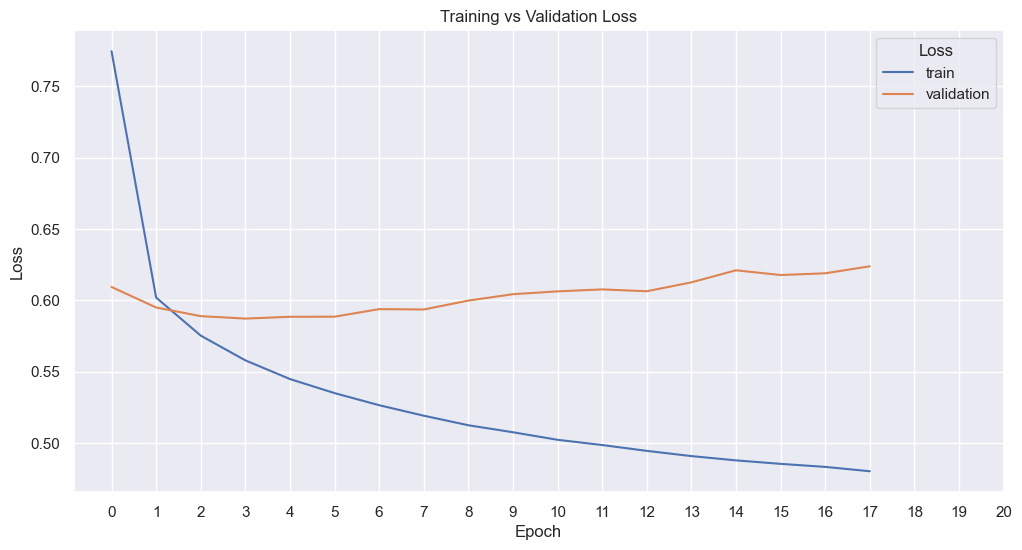

In [15]:
df = pd.DataFrame({
    'epoch': history.epoch,
    'train': history.history['loss'],
    'validation': history.history['val_loss']
})

# Melt to long format
df_melted = df.melt(id_vars='epoch', value_vars=['train', 'validation'],
                    var_name='Loss', value_name='loss')

# Plot
sns.lineplot(data=df_melted, x='epoch', y='loss', hue='Loss')
plt.title('Training vs Validation Loss')
plt.xticks(range(0, epochs+1, 1))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

A progressão da loss mostrou uma degradação rápida no gráfico, indicando que o modelo ainda não está conseguindo capturar bem a complexidade dos dados. A partir da época 3, o erro de validação já começou a subir de forma consistente, indicando um overfit do modelo, já que o erro de treinamento manteve uma queda constante.

### Avaliando o modelo treinado

**Atividade (1 pt):** teste o modelo treinado utilizando o subconjunto de teste. Reporte a acurácia para cada classe e a matriz de confusão percentual (usando a função `evaluate` definida anteriormente).

In [ ]:
y_pred = model.predict(nn_X_test)

In [ ]:
## para poder usar a função, precisei utilizar o dataset ye_test, sem one hot encoding
evaluate(ye_test, np.argmax(y_pred, axis=1), y_pred, labels=label_enc.classes_)

--------

Repita agora a definição, treinamento e avaliação de uma rede neural mais complexa, aumentando o número de camadas ou a quantidade de neurônios nas camadas da rede anterior:

**Atividade (1 pt):** defina uma rede neural mais complexa e a compile com as mesmas configurações da rede anterior.

In [16]:
model2 = Sequential([
    Input(shape=(features,)),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(6, activation='softmax')
])

model2.compile(
    optimizer=optimizers.SGD(learning_rate=1e-2, momentum=0.9),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

**Atividade (1 pt):** treine a nova rede.

In [18]:
tf.random.set_seed(42)
np.random.seed(42)
epochs = 20
batch_size = 128

earlystop2 = EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=5,
    restore_best_weights=True
)


checkpoint2 = ModelCheckpoint(
    filepath="weights2.h5",
    monitor='val_accuracy',
    mode='max',
    verbose=1
)


history2 = model2.fit(
    nn_X_train, nn_y_train,
    validation_data=(nn_X_val, nn_y_val),
    epochs=epochs,
    batch_size=batch_size,
    class_weight=train_class_weights,
    callbacks=[earlystop2, checkpoint2],
)

Epoch 1/20
718/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8919 - loss: 0.2925
Epoch 1: saving model to weights2.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8799 - loss: 0.3267 - val_accuracy: 0.8096 - val_loss: 0.6550
Epoch 2/20
700/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8841 - loss: 0.3105
Epoch 2: saving model to weights2.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8798 - loss: 0.3209 - val_accuracy: 0.8036 - val_loss: 0.6871
Epoch 3/20
703/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8905 - loss: 0.2962
Epoch 3: saving model to weights2.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8876 - loss: 0.3000 - val_accuracy: 0.7994 - val_loss: 0.7312
Epoch 4/20
705/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8938 - loss: 0.2792
Epoch 4: saving model to weights2.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8914 - loss: 0.2828 - val_accuracy: 0.8049 - val_loss: 0.7430
Epoch 5/20
711/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8984 - loss: 0.2646
Epoch 5: saving model to weights2.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8959 - loss: 0.2689 - val_accuracy: 0.7960 - val_loss: 0.8027
Epoch 6/20
699/720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9006 - loss: 0.2562
Epoch 6: saving model to weights2.h5


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8982 - loss: 0.2612 - val_accuracy: 0.7933 - val_loss: 0.8341


**Atividade (1 pt):** adicione dropout ou regularização L1/L2 e treine o novo modelo. Se for, preciso, faça uma busca pelos hipeparâmetros da regularização/dropout.

In [39]:
tf.random.set_seed(42)
np.random.seed(42)

reg = None #L2(l2=1e-3)
mom = 0.7

model3 = Sequential([
    Input(shape=(features,)),
    # input já sofreu StandardScaling
    Dense(512, activation='relu', kernel_regularizer=reg),
    BatchNormalization(momentum=mom),
    Dense(64, activation='relu', kernel_regularizer=reg),
    BatchNormalization(momentum=mom),
    Dense(6, activation='softmax')
])

model3.compile(
    optimizer=optimizers.SGD(learning_rate=1e-2, momentum=mom),
    loss=CategoricalCrossentropy(label_smoothing=0.05),
    metrics=["accuracy"]
)

epochs = 50
batch_size = 128

earlystop3 = EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

checkpoint3 = ModelCheckpoint(
    filepath="weights3.h5",
    monitor='val_accuracy',
    mode='max',
    verbose=0
)

reduce_lr_loss = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=4, verbose=1, epsilon=1e-4, mode='max')


history3 = model3.fit(
    nn_X_train, nn_y_train,
    validation_data=(nn_X_val, nn_y_val),
    epochs=epochs,
    batch_size=batch_size,
    class_weight=train_class_weights,
    callbacks=[earlystop3, checkpoint3, reduce_lr_loss],
    verbose=2
)

Epoch 1/50


720/720 - 6s - 8ms/step - accuracy: 0.7143 - loss: 0.9530 - val_accuracy: 0.7686 - val_loss: 0.7895 - learning_rate: 0.0100
Epoch 2/50


720/720 - 4s - 6ms/step - accuracy: 0.8247 - loss: 0.7002 - val_accuracy: 0.7929 - val_loss: 0.7509 - learning_rate: 0.0100
Epoch 3/50


720/720 - 4s - 6ms/step - accuracy: 0.8639 - loss: 0.6051 - val_accuracy: 0.8084 - val_loss: 0.7319 - learning_rate: 0.0100
Epoch 4/50


720/720 - 4s - 6ms/step - accuracy: 0.8986 - loss: 0.5242 - val_accuracy: 0.8174 - val_loss: 0.7261 - learning_rate: 0.0100
Epoch 5/50


720/720 - 5s - 6ms/step - accuracy: 0.9270 - loss: 0.4592 - val_accuracy: 0.8224 - val_loss: 0.7291 - learning_rate: 0.0100
Epoch 6/50


720/720 - 4s - 6ms/step - accuracy: 0.9484 - loss: 0.4119 - val_accuracy: 0.8247 - val_loss: 0.7366 - learning_rate: 0.0100
Epoch 7/50


720/720 - 4s - 6ms/step - accuracy: 0.9641 - loss: 0.3784 - val_accuracy: 0.8259 - val_loss: 0.7460 - learning_rate: 0.0100
Epoch 8/50


720/720 - 4s - 6ms/step - accuracy: 0.9750 - loss: 0.3548 - val_accuracy: 0.8262 - val_loss: 0.7547 - learning_rate: 0.0100
Epoch 9/50


720/720 - 5s - 6ms/step - accuracy: 0.9826 - loss: 0.3377 - val_accuracy: 0.8256 - val_loss: 0.7629 - learning_rate: 0.0100
Epoch 10/50


720/720 - 4s - 6ms/step - accuracy: 0.9874 - loss: 0.3251 - val_accuracy: 0.8244 - val_loss: 0.7695 - learning_rate: 0.0100
Epoch 11/50


720/720 - 5s - 6ms/step - accuracy: 0.9909 - loss: 0.3156 - val_accuracy: 0.8229 - val_loss: 0.7750 - learning_rate: 0.0100
Epoch 12/50



Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
720/720 - 4s - 6ms/step - accuracy: 0.9933 - loss: 0.3083 - val_accuracy: 0.8221 - val_loss: 0.7793 - learning_rate: 0.0100
Epoch 13/50


720/720 - 4s - 6ms/step - accuracy: 0.9956 - loss: 0.2996 - val_accuracy: 0.8214 - val_loss: 0.7790 - learning_rate: 1.0000e-03
Epoch 14/50


720/720 - 4s - 6ms/step - accuracy: 0.9960 - loss: 0.2984 - val_accuracy: 0.8215 - val_loss: 0.7794 - learning_rate: 1.0000e-03
Epoch 15/50


720/720 - 4s - 6ms/step - accuracy: 0.9962 - loss: 0.2977 - val_accuracy: 0.8212 - val_loss: 0.7797 - learning_rate: 1.0000e-03
Epoch 16/50



Epoch 16: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
720/720 - 4s - 6ms/step - accuracy: 0.9964 - loss: 0.2971 - val_accuracy: 0.8211 - val_loss: 0.7801 - learning_rate: 1.0000e-03
Epoch 17/50


720/720 - 4s - 6ms/step - accuracy: 0.9965 - loss: 0.2963 - val_accuracy: 0.8215 - val_loss: 0.7799 - learning_rate: 1.0000e-04
Epoch 18/50


720/720 - 4s - 6ms/step - accuracy: 0.9966 - loss: 0.2962 - val_accuracy: 0.8217 - val_loss: 0.7798 - learning_rate: 1.0000e-04
Epoch 18: early stopping
Restoring model weights from the end of the best epoch: 8.


**Atividade (1 pt):** avalie os modelos treinados e compare com os resultados anteriores.

In [ ]:
y_pred2 = model2.predict(nn_X_test)
y_pred3 = model3.predict(nn_X_test)

Curiosamente, o primeiro modelo testado, muito mais simples, se mostrou muito superior a todos os outros, mesmo após algumas tentativas de regularização e mudanças em outros hiperparâmetros. O primeiro modelo de rede neural, com apenas uma hidden layer de 50 unidades, conseguiu atingir uma acurácia de 72%, enquanto os outros foram muito piores. Tentamos investigar motivos, mas em todos os treinamentos dos modelos seguintes, o comportamento do loss sempre foi ascendente na validação, mostrando grande dificuldade de aprendizado nos modelos.

In [ ]:
print(metrics.classification_report(ye_test, np.argmax(y_pred, axis=1), target_names=label_enc.classes_))

In [ ]:

print(metrics.classification_report(ye_test, np.argmax(y_pred2, axis=1), target_names=label_enc.classes_))

In [ ]:
print(metrics.classification_report(ye_test, np.argmax(y_pred3, axis=1), target_names=label_enc.classes_))